# Deep Learning with PyTorch: Dance Move Detector  
Course: CS506 Team Project  
Assignment: Submission #3  
Topic: Pose-based Dance Move Classification using CNN  
Team Members: Veronica Elze, Hiromi Cota, & Ixius Procopios

# 🧩 STEP 0: Imports & Setup

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import numpy as np
import json
import matplotlib.pyplot as plt
from pathlib import Path
import os
from pandas import DataFrame    # To create visualization

# Reuse logic from previous submissions
from pose_tools_byH import poses_to_vectors

# 📥 STEP 1: Load and Prepare Dataset

In [2]:
class DancePoseDataset(Dataset):
    def __init__(self, poses_dir):
        self.samples = []
        self.keypoints = []
        self.labels = []
        self.label_dict = {}
        files = [f for f in os.listdir(poses_dir) if f.endswith('.json')]
        for idx, f in enumerate(files):
            label_name = f.split('_')[0]  # Extract label from filename
            if label_name not in self.label_dict:
                self.label_dict[label_name] = len(self.label_dict)

            try:
                with open(os.path.join(poses_dir, f), 'r') as file:
                    data = json.load(file)
                keypoints = data[0]['people'][0]['pose_keypoints_2d']
                keypoints_array = np.array(keypoints).reshape(-1, 3)[:, :2]
                self.samples.append(keypoints_array.flatten())
                self.keypoints.append(keypoints_array)
                self.labels.append(self.label_dict[label_name])
            except Exception as e:
                print(f"Skipping file {f} due to error: {e}")

        # Standardize features
        self.scaler = StandardScaler()
        self.samples = self.scaler.fit_transform(self.samples)
        self.samples = torch.tensor(self.samples, dtype=torch.float32)
        self.labels = torch.tensor(self.labels, dtype=torch.long)

        # Visualization: Sample distribution
        self.visualize_sample_distribution()

    def visualize_sample_distribution(self):
        labels, counts = np.unique(self.labels.numpy(), return_counts=True)
        plt.bar(labels, counts, tick_label=[label for label, idx in self.label_dict.items()])
        plt.title("Distribution of Dance Pose Samples")
        plt.xlabel("Dance Pose")
        plt.ylabel("Count")
        plt.show()

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx], self.labels[idx], self.keypoints[idx]

# 🧠 STEP 2: Define Neural Network (CNN)

In [3]:
class DanceNet(nn.Module):
    def __init__(self, input_size, num_classes):
        super(DanceNet, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.fc(x)

# 🎯 STEP 3: Train the Network

In [4]:
def train(model, dataloader, criterion, optimizer, epochs=20):
    loss_values = []
    for epoch in range(epochs):
        epoch_loss = 0
        for x, y, _ in dataloader:
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        epoch_loss /= len(dataloader)
        loss_values.append(epoch_loss)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")
        
        # Interim Loss Visualization every 5 epochs
        if (epoch + 1) % 5 == 0:
            plt.plot(loss_values, color='blue', linestyle='--', alpha=0.6)
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.title(f"Training Loss Curve (Epoch {epoch+1})")
            plt.grid(True)
            plt.show()
            
    return loss_values

# 🔍 STEP 4: Evaluate the Model

In [5]:
def evaluate(model, dataloader):
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for x, y, _ in dataloader:
            outputs = model(x)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.numpy())
            all_labels.extend(y.numpy())

    cm = confusion_matrix(all_labels, all_preds)
    acc = accuracy_score(all_labels, all_preds)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(len(set(all_labels)))))
    disp.plot()
    plt.title(f'Confusion Matrix (Accuracy: {acc:.2%})')
    plt.show()

# 📊 STEP 5: Plot Loss Curve

In [6]:
def plot_loss_curve(losses):
    plt.figure(figsize=(10,6))
    plt.plot(losses, color='red', linewidth=2.5, marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("FINAL Training Loss Curve", fontsize=16, fontweight='bold')
    plt.grid(True)
    plt.show()

# 💃 STEP 6: Visualize Actual Poses

In [7]:
def visualize_pose(keypoints, title):
    plt.figure()
    plt.scatter(keypoints[:, 0], keypoints[:, 1])
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(True)
    plt.show()

# 🚀 STEP 7: Main Execution Block

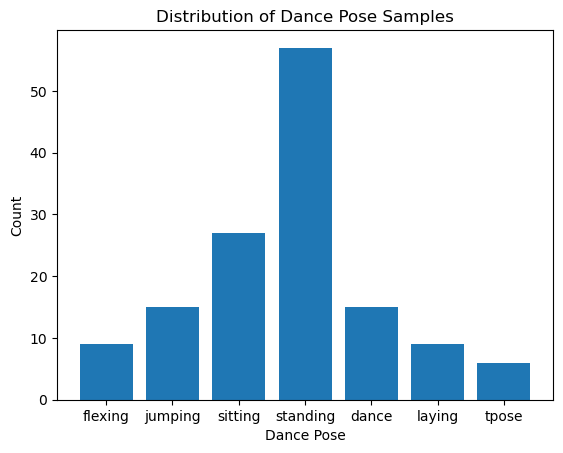

Epoch 1/20, Loss: 1.7677
Epoch 2/20, Loss: 1.3137
Epoch 3/20, Loss: 1.0746
Epoch 4/20, Loss: 0.8996
Epoch 5/20, Loss: 0.7793


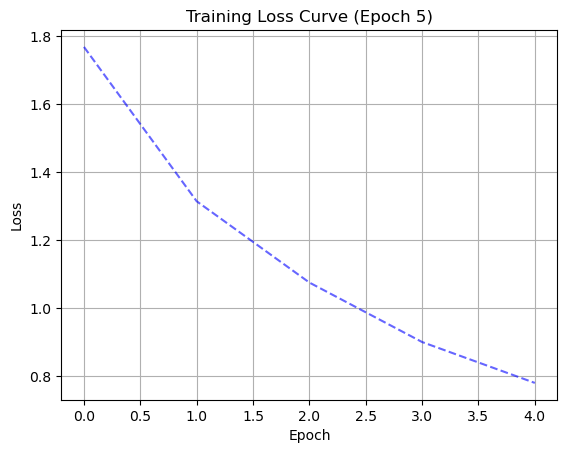

Epoch 6/20, Loss: 0.6638
Epoch 7/20, Loss: 0.5729
Epoch 8/20, Loss: 0.4977
Epoch 9/20, Loss: 0.4210
Epoch 10/20, Loss: 0.3627


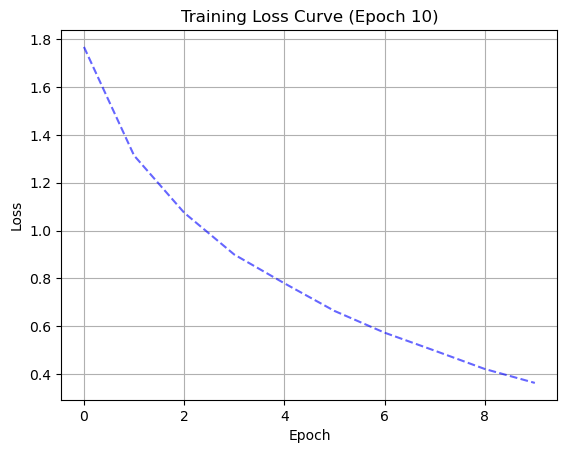

Epoch 11/20, Loss: 0.3159
Epoch 12/20, Loss: 0.2761
Epoch 13/20, Loss: 0.2440
Epoch 14/20, Loss: 0.2103
Epoch 15/20, Loss: 0.1886


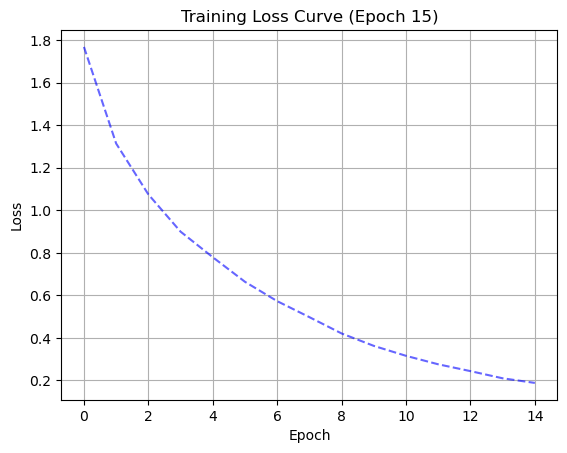

Epoch 16/20, Loss: 0.1633
Epoch 17/20, Loss: 0.1506
Epoch 18/20, Loss: 0.1263
Epoch 19/20, Loss: 0.1105
Epoch 20/20, Loss: 0.0997


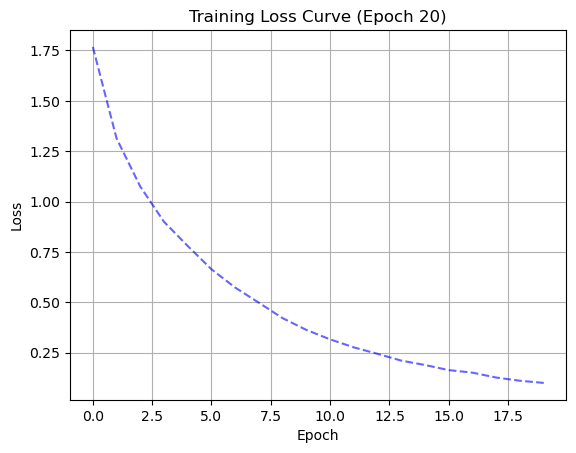

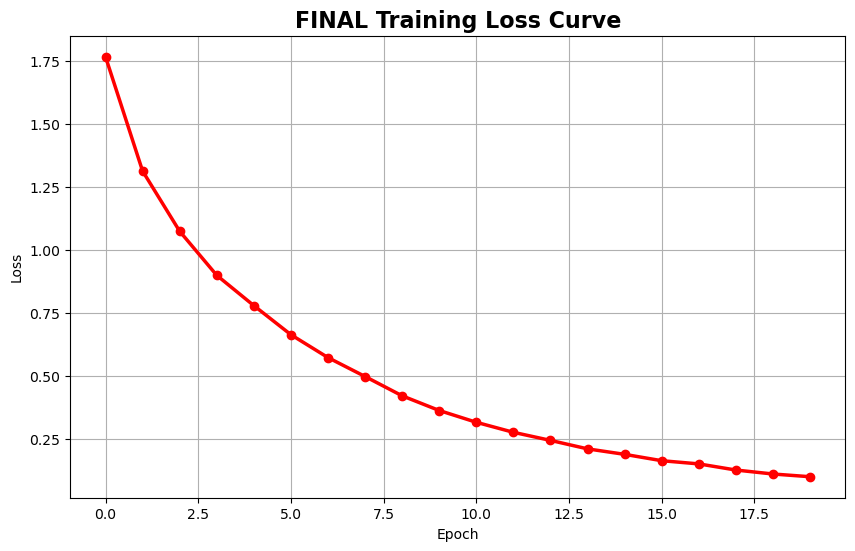

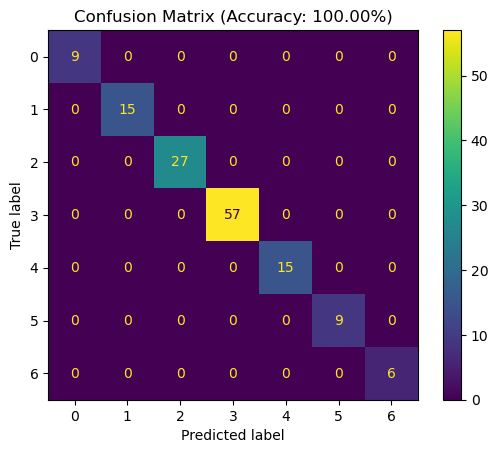

Model saved to sub3_dancemoves_model.pt


In [8]:
if __name__ == '__main__':
    poses_dir = Path("./poses")
    dataset = DancePoseDataset(poses_dir)
    dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

    input_size = dataset.samples.shape[1]
    num_classes = len(dataset.label_dict)

    model = DanceNet(input_size, num_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    loss_history = train(model, dataloader, criterion, optimizer, epochs=20)

    plot_loss_curve(loss_history)
    evaluate(model, dataloader)

    model_save_path = Path("./sub3_dancemoves_model.pt")
    torch.save(model.state_dict(), model_save_path)
    print(f"Model saved to {model_save_path}")

# 📽️ BONUS STEP: Visualizations

In [91]:
# Step 1. Pick 2 poses to use for visualization
# Step 2. Load pose data for vector generation
# Step 3a. Generate column labels for DataFrames
# Step 3b. Convert pose list object to DataFrame
# Step 3c. Calculate vectors
# Step 4. Generate image from vectors
# Step 5. Display poses and vector image

def read_one_pose(json_file,path="poses"):
    item = path + "/" + json_file
    with open(item) as file:
        data = json.load(file)
        points_list = list(data[0]["people"][0]["pose_keypoints_2d"])
        unndeed_3d_coord = 1.0
        points_list = [i for i in points_list if i != unndeed_3d_coord]
        return points_list
    
def generate_column_labels(coords=18):
    labels = []
    for i in range(coords):
        formatted_number = f"{i:02d}"           # Formats to 2 digit string representation of int, which will only work well to 99 points
        labels.append(formatted_number + "x")
        labels.append(formatted_number + "y")
    return labels

def coords_to_vectors(pose1, pose2, labels):
    movement = []
    for j in range(len(labels)):
        movement.append(pose2.iloc[0,j] - pose1.iloc[0,j])
    print(movement)
    vects = DataFrame(np.array(movement).reshape(-1,len(movement)), columns=labels)
    vects.reset_index(drop=True, inplace=True)
    display(vects)
    return vects

def generate_vector_graph(pose, movement, title, output_filename):
    plt.figure(figsize=(8, 8))
    #plt.title(f"Movement Vectors: {title}")

    for i in range(0, pose.shape[1], 2):  # every (x, y) pair
        x = pose.iloc[0][i]
        y = pose.iloc[0][i+1]
        dx = movement.iloc[0][i]
        dy = movement.iloc[0][i+1] 
    
        plt.quiver(x, y, dx, dy, angles='xy', scale_units='xy', scale=5, color='blue')

    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(True)
    plt.axis('off')
    #plt.gca().set_aspect('equal')
    plt.gca().invert_yaxis()
    plt.savefig(f"diagrams/{output_filename}.png",bbox_inches='tight')
    plt.close()



[-126.33982146448557, 6.405835694736936, -82.29379858904417, -5.636062542597358, -94.58888134691449, -5.709267344739658, -172.43042774995166, -154.2116415368185, -100.63039628664637, -289.1971359186703, -69.99871583117385, -5.562857740455058, -35.85985287692813, -34.200475003984195, -15.438123557302788, -135.0924755997127, -10.720943060186187, -0.948544727431397, 38.954288052188076, 2.826031823952917, 65.42600736353143, 32.20899311701464, -10.105058530966517, -39.15663048956122, 169.49182303746556, -224.07992908027444, 266.2069123850929, -220.94483516613644, -124.30521006054346, 4.795330047607365, -116.76087791389898, 3.8243070377243953, -105.80192865265747, 5.527378069030021, -98.92067725128595, 1.0576476123598582]


,00x,00y,01x,01y,02x,02y,03x,03y,04x,04y,...,13x,13y,14x,14y,15x,15y,16x,16y,17x,17y
0,-126.339821,6.405836,-82.293799,-5.636063,-94.588881,-5.709267,-172.430428,-154.211642,-100.630396,-289.197136,...,266.206912,-220.944835,-124.30521,4.79533,-116.760878,3.824307,-105.801929,5.527378,-98.920677,1.057648


/var/folders/gq/k4nf9j812j53tksmbwh1rz0r0000gn/T/ipykernel_41670/247231724.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x = pose.iloc[0][i]
/var/folders/gq/k4nf9j812j53tksmbwh1rz0r0000gn/T/ipykernel_41670/247231724.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = pose.iloc[0][i+1]
/var/folders/gq/k4nf9j812j53tksmbwh1rz0r0000gn/T/ipykernel_41670/247231724.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dx = movem

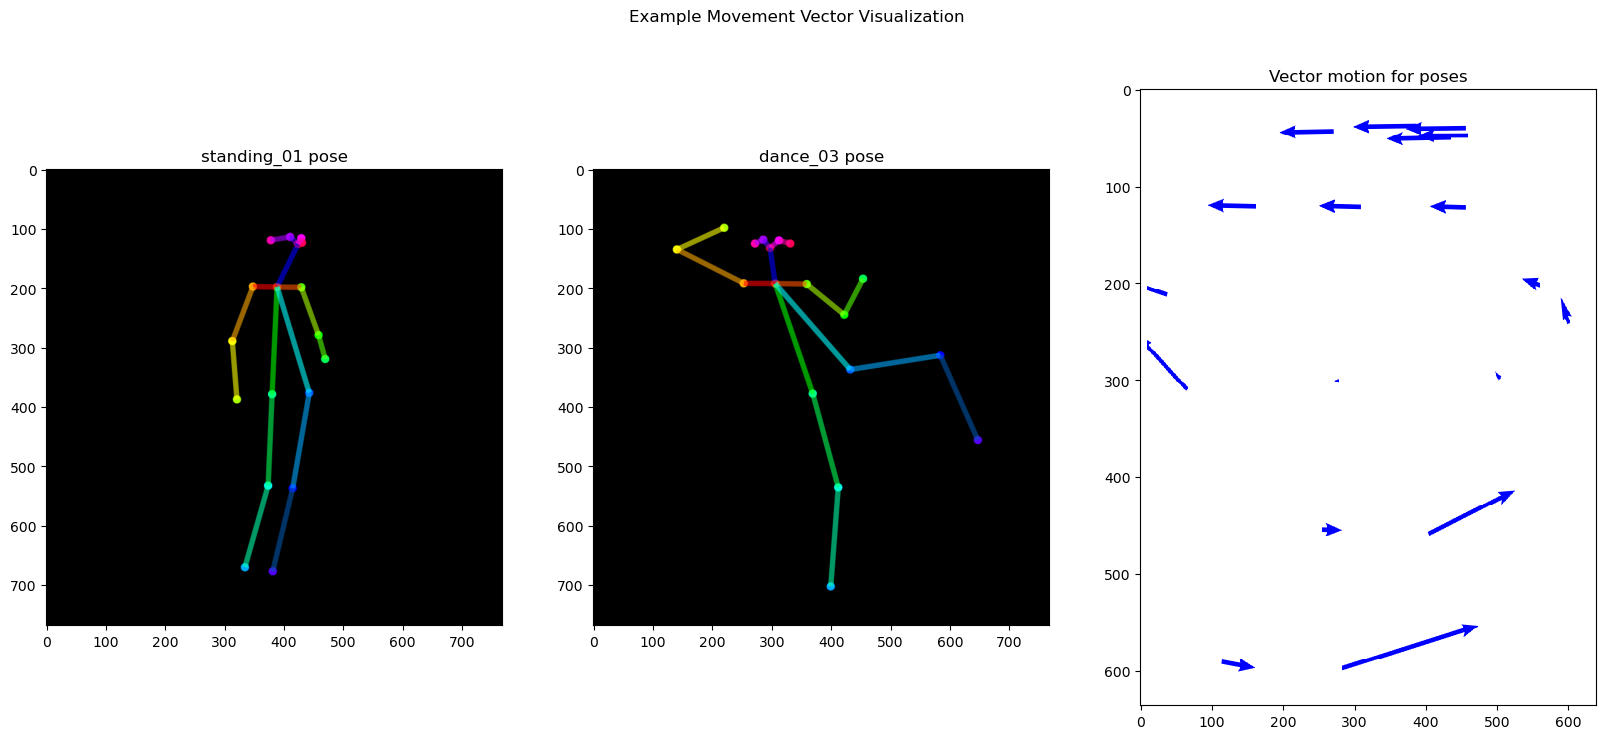

In [92]:
labels = generate_column_labels()

standing_pose = read_one_pose("standing_01.json")
kicking_pose = read_one_pose("dance_03.json")
standing_df = DataFrame(np.array(standing_pose).reshape(-1,len(standing_pose)),columns=labels)
kicking_df = DataFrame(np.array(kicking_pose).reshape(-1,len(kicking_pose)), columns=labels)
movement_df = coords_to_vectors(standing_df, kicking_df, labels=labels)
generate_vector_graph(standing_df, movement_df, "Example Kick Move","example_kick")

img_dir = "submission1/post_images/"
standing_img = img_dir + "standing_01.png"
standing_img = plt.imread(standing_img)
kicking_img = img_dir + "dance_03.png"
kicking_img = plt.imread(kicking_img)
vector_img = "diagrams/example_kick.png"
vector_img = plt.imread(vector_img)
fig, axarr = plt.subplots(1,3, figsize=[20,8])
fig.suptitle("Example Movement Vector Visualization")
axarr[0].imshow(standing_img)
axarr[0].title.set_text("standing_01 pose")
axarr[1].imshow(kicking_img)
axarr[1].title.set_text("dance_03 pose")
axarr[2].imshow(vector_img,interpolation='nearest',aspect='auto')
axarr[2].title.set_text("Vector motion for poses")
plt.show()



# REFERENCES 

OpenAI. (2025). ChatGPT’s assistance with CS506 TP03 Dance Detector [Large language model]. https://openai.com/chatgpt  
PyTorch. (n.d.). https://pytorch.org/docs/stable/index.html  
Scikit-Learn. (n.d.). StandardScaler, accuracy_score, confusion_matrix. https://scikit-learn.org/stable/modules/classes.html